In [18]:
import requests, bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import dateutil.parser
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [3]:
url_list = ['https://www.boxofficemojo.com/year/2015','https://www.boxofficemojo.com/year/2016',
            'https://www.boxofficemojo.com/year/2017','https://www.boxofficemojo.com/year/2018',
           'https://www.boxofficemojo.com/year/2019','https://www.boxofficemojo.com/year/2020',
           'https://www.boxofficemojo.com/year/2021','https://www.boxofficemojo.com/year/2022']
#url_list = ['https://www.boxofficemojo.com/year/2021','https://www.boxofficemojo.com/year/2022']
mov_list = []
movie_data = []
for url_item in url_list:
    response = requests.get(url_item)
    status = response.status_code
    if status == 200:
        page = response.text
        soup = bs(page)
        time.sleep(.5+2*random.random())
    else:
        print(f"Oops! Received status code {status}")
        
    for mov in soup.find_all(class_='a-text-left mojo-field-type-release mojo-cell-wide'):
        href_tag = mov.find('a')
        link_part = href_tag['href'].split('/?')[0]
        link = 'https://www.boxofficemojo.com'+ link_part
        mov_name = href_tag.text
        mov_list.append({'title': mov_name,'link': link})

len(mov_list)

1500

In [4]:
df = pd.DataFrame(mov_list)
df.drop_duplicates(keep = 'first', inplace = True)
df.drop_duplicates(subset = 'title', keep = 'first', inplace = True)
duplicate = df[df.duplicated(['title'])]
df.nunique()
  

title    1336
link     1336
dtype: int64

In [8]:
#All functions to scrape and convert datatypes

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def to_percentage(percentstring):
    perc = percentstring.split('%')
    try:
        percentage = float(perc[0])
        return percentage
    except:
        return None
def get_movie_value(soup, field_name,next_num):
       
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    if next_num == 1: 
        next_element = obj.findNext()
    
        if next_element:
            return next_element.text 
        else:
            return None
    if next_num == 2:
       
        next_obj_element = obj.next.next
    
        if next_obj_element:
            return next_obj_element.text 
        else:
            return None


def get_movie_data(url_mov):
    response = requests.get(url_mov)
    status = response.status_code
    if status == 200:
      page = response.text
      soup = bs(page,'html.parser')
    else:
      print(f"Oops! Received status code {status}")
    mov_title = soup.find("h1",attrs={"class":"a-size-extra-large"}).text

    mov_features = soup.find(class_ = 'a-section a-spacing-none mojo-performance-summary-table')
    p_tag = mov_features.find_all(class_ = 'percent')
    p_dom_gross = p_tag[0].text
    dom_percentage = to_percentage(p_dom_gross)
    p_int_gross = p_tag[1].text
    int_percentage = to_percentage(p_int_gross)


    #m_tag = mov_features.find_all(class_ = 'money')
    dom_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    dom_total_gross = money_to_int(dom_gross)
    #int_gross = m_tag[1].text
    #int_total_gross = money_to_int(int_gross)
    #tot_gross = m_tag[2].text
    #total_gross = money_to_int(tot_gross)

    dist_name = get_movie_value(soup,'Distributor',1)
    if dist_name is not None:
        dist_name = dist_name.replace('See full company information\n\n','')
    else:
         dist_name = dist_name
    
    
    mpaa = get_movie_value(soup,'MPAA',1)

    running_time = get_movie_value(soup,'Running Time',1)
    if running_time is not None:
        run_minutes = runtime_to_minutes(running_time)
    else:
         run_minutes = running_time

    genres = get_movie_value(soup,'Genres',1)
    if genres is not None:
        genres_format = genres.replace('\n',',').replace(' , ','').replace(' ','')
    else:
        genres_format = genres

    in_release_days = get_movie_value(soup,'In Release',1)
    if in_release_days is not None:
         in_release_days = int(in_release_days.split('/')[0].split(' days')[0].replace(',','')) 
    else:
         in_release_days = in_release_days

    num_theaters = get_movie_value(soup,'Widest Release',1)
    if num_theaters is not None:
         num_theaters = int(num_theaters.split(' ')[0].replace(',',''))
    else:
         num_theaters = num_theaters

    opening = get_movie_value(soup,'Opening',2)
    if opening is not None:
        opening_amt = money_to_int(opening)
    else:
        opening_amt = opening

    budget = get_movie_value(soup,'Budget',2)
    if budget is not None:
        budget_amt = money_to_int(budget)
    else:
        budget_amt = budget

    release_date = get_movie_value(soup,'Release Date',2)
    if release_date is not None:
        rel_date = to_date(release_date) 
    else:
        rel_date = release_date

    
    column_headers = ['title','dist_name', 'opening',
                      'budget','release_date','mpaa','running_time',
                      'genres','in_release_days','percentage_dom',
                      'gross_dom','num_theaters']


    movie_dict = dict(zip(column_headers, [mov_title, dist_name, opening_amt,
                                       budget_amt, rel_date, mpaa, run_minutes,
                                       genres_format, in_release_days, dom_percentage,
                                       dom_total_gross, num_theaters]))

   
    time.sleep(.5+2*random.random())
    return movie_dict


#df = pd.DataFrame([features_dict,features_dict2])


In [9]:
movie_data = []

In [10]:
# this takes about 50 minutes to run- Scraping pipeline - get all the scraped data into movie_data list
movie_url_list = []
for i in range(len(df)):
  movie_url_list.append(df.iloc[i,1])


for movie_url in movie_url_list:
    movie_data.append(get_movie_data(movie_url))
    
movie_data

[{'title': 'Jurassic World',
  'dist_name': 'Universal Pictures',
  'opening': 208806270,
  'budget': 150000000,
  'release_date': datetime.datetime(2015, 6, 12, 0, 0),
  'mpaa': 'PG-13',
  'running_time': 124,
  'genres': 'Action,Adventure,Sci-Fi',
  'in_release_days': 210,
  'percentage_dom': 39.0,
  'gross_dom': 652270625,
  'num_theaters': 4291},
 {'title': 'Star Wars: Episode VII - The Force Awakens',
  'dist_name': 'Walt Disney Studios Motion Pictures',
  'opening': 247966675,
  'budget': 245000000,
  'release_date': datetime.datetime(2015, 12, 18, 0, 0),
  'mpaa': 'PG-13',
  'running_time': 138,
  'genres': 'Action,Adventure,Sci-Fi',
  'in_release_days': 380,
  'percentage_dom': 45.3,
  'gross_dom': 936662225,
  'num_theaters': 4134},
 {'title': 'Avengers: Age of Ultron',
  'dist_name': 'Walt Disney Studios Motion Pictures',
  'opening': 191271109,
  'budget': 250000000,
  'release_date': datetime.datetime(2015, 5, 1, 0, 0),
  'mpaa': 'PG-13',
  'running_time': 141,
  'genres': 

In [14]:
#convert list to a dataframe
movie_df = pd.DataFrame(movie_data)
movie_df.head()


,title,dist_name,opening,budget,release_date,mpaa,running_time,genres,in_release_days,percentage_dom,gross_dom,num_theaters
0,Jurassic World,Universal Pictures,208806270.0,150000000.0,2015-06-12,PG-13,124.0,"Action,Adventure,Sci-Fi",210.0,39.0,652270625,4291.0
1,Star Wars: Episode VII - The Force Awakens,Walt Disney Studios Motion Pictures,247966675.0,245000000.0,2015-12-18,PG-13,138.0,"Action,Adventure,Sci-Fi",380.0,45.3,936662225,4134.0
2,Avengers: Age of Ultron,Walt Disney Studios Motion Pictures,191271109.0,250000000.0,2015-05-01,PG-13,141.0,"Action,Adventure,Sci-Fi",245.0,32.7,459005868,4276.0
3,Inside Out,Walt Disney Studios Motion Pictures,90440272.0,175000000.0,2015-06-19,PG,95.0,"Adventure,Animation,Comedy,Drama,Family,Fantasy",203.0,41.6,356461711,4158.0
4,Furious 7,Universal Pictures,147187040.0,190000000.0,2015-04-03,PG-13,137.0,"Action,Crime,Thriller",273.0,23.3,353007020,4022.0


In [16]:
#Save the raw data in to a .csv file called movie_df_1.csv
movie_df.to_csv(r'/Users/archana/Desktop/MEtis/Regression/regression_project/movie_df_1.csv', index = None, header=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1336 non-null   object 
 1   dist_name        1330 non-null   object 
 2   opening          1313 non-null   float64
 3   budget           591 non-null    float64
 4   release_date     1335 non-null   object 
 5   mpaa             1183 non-null   object 
 6   running_time     1301 non-null   float64
 7   genres           1333 non-null   object 
 8   in_release_days  1335 non-null   float64
 9   percentage_dom   1329 non-null   float64
 10  gross_dom        1336 non-null   int64  
 11  num_theaters     1331 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 125.4+ KB


Text(0.5, 1.0, 'Multiple Genres')

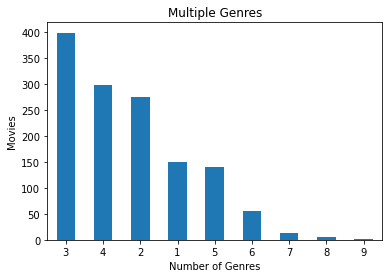

In [19]:
df = pd.read_csv ('/Users/archana/Desktop/MEtis/Regression/regression_project/movie_df_1.csv')
df.info()
df.isnull().sum()
df[df['release_date'].isnull()]
#manually imputing missing date value for the movie title 'Scott Pilgrim vs. the World'
#then converting the column to datetime 
df["release_date"].fillna("2010-08-13", inplace = True) 
df['release_date']= pd.to_datetime(df['release_date'])

#since a lot of rows are missing Budget data, dropping this column altogether.
df.drop('budget', axis=1, inplace=True)

# 2 movies are missing genres, so imputed them with 'Family' genre
df[df['genres'].isnull()]
df["genres"].fillna("Family", inplace = True) 

#Changing genres string to a list and calculating the length to get the number of genres a film is associated with.
df['genres_num'] = df['genres'].apply(lambda x: len(x.split(',')))
#df['genres_num'] = df['genres'].apply(lambda x: len(x))

df['genres_num'].value_counts(ascending = False).plot(kind="bar",xlabel = 'Number of Genres',ylabel = 'Movies')
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Multiple Genres")

In [20]:
#missing distributer name is replaced with 'Other'
df["dist_name"].fillna("Other", inplace = True) 

#missing Percentage of domestic release 7 entries replaced with average of that columns
#df.iloc[[1041, 1065, 1236,1262,1292,1294,1332]]
df[df['percentage_dom'].isnull()]
df['percentage_dom'].fillna((df['percentage_dom'].mean()), inplace=True)
df.round({'percentage_dom': 1}).head(2)

#filling missing mpaa with 'Not Rated'
df["mpaa"].fillna("Not Rated", inplace=True)

# to get the top 3 most common disctributers
df4 = df.groupby('dist_name').count().sort_values(by = 'title', ascending = False)
df4.head(3)

#23 movies do not have opening . so imputing it with average of the column
df[df['opening'].isna()]
df['opening'].fillna((df['opening'].mean()), inplace=True)

#Running time missing values are imputed with mean of that column
df[df['running_time'].isna()]
df['running_time'].fillna((df['running_time'].mean()), inplace=True)

# 1 row has missing 'in release days' so imputing it with mean
df[df['in_release_days'].isna()]
df['in_release_days'].fillna((df['in_release_days'].mean()), inplace=True)

#5 rows have missing number of theaters column, so imputing with mean.
df[df['num_theaters'].isna()]
df['num_theaters'].fillna((df['num_theaters'].mean()), inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            1336 non-null   object        
 1   dist_name        1336 non-null   object        
 2   opening          1336 non-null   float64       
 3   release_date     1336 non-null   datetime64[ns]
 4   mpaa             1336 non-null   object        
 5   running_time     1336 non-null   float64       
 6   genres           1336 non-null   object        
 7   in_release_days  1336 non-null   float64       
 8   percentage_dom   1336 non-null   float64       
 9   gross_dom        1336 non-null   int64         
 10  num_theaters     1336 non-null   float64       
 11  genres_num       1336 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 125.4+ KB


In [22]:
# now Data is all cleaned. save it to movie_df_2.csv for further analysis
df.to_csv(r'/Users/archana/Desktop/MEtis/Regression/regression_project/movie_df_2.csv', index = None, header=True)